# DETR

In [5]:
import os
import json
import shutil
import platform
import random
import subprocess
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from pathlib import Path
from collections import Counter, OrderedDict
from typing import Any, Dict, List, Optional, Tuple
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from transformers import DetrImageProcessor, DetrForObjectDetection
import transformers
import pytorch_lightning as pl
from torchmetrics.detection.mean_ap import MeanAveragePrecision


In [2]:
# 프로젝트 루트 탐색

# 한 번만 찾고 고정
def find_project_root(marker_filename=".project-root"):
    current_dir = os.path.abspath(os.getcwd())
    while True:
        if os.path.isfile(os.path.join(current_dir, marker_filename)):
            return current_dir
        parent_dir = os.path.dirname(current_dir)
        if parent_dir == current_dir:
            raise FileNotFoundError(f"Could not find {marker_filename} in any parent directory.")
        current_dir = parent_dir
        
# 경로/출력 폴더 생성(find_project_root() 호출 후 사용)
def ensure_dir(path):
    # 디렉토리 없으면 생성
    os.makedirs(path, exist_ok=True)

PROJECT_ROOT = find_project_root()
def get_project_path(*paths):
    return os.path.join(PROJECT_ROOT, *paths)

In [5]:
print("=" * 60)
print("EXPERIMENTAL ENVIRONMENT")
print("=" * 60)

# 하드웨어 정보
print("\n[Hardware]")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"  Device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"  GPU: {gpu_name}")
    print(f"  GPU Memory: {gpu_memory:.1f} GB")
    print(f"  CUDA Version: {torch.version.cuda}")
    if torch.backends.cudnn.is_available():
        print(f"  cuDNN Version: {torch.backends.cudnn.version()}")

# CPU 정보
print(f"  CPU: {platform.processor()}")
print(f"  CPU Cores: {os.cpu_count()}")

# 소프트웨어 정보
print("\n[Software]")
print(f"  OS: {platform.system()} {platform.release()}")
print(f"  Python: {platform.python_version()}")
print(f"  PyTorch: {torch.__version__}")
print(f"  Torchvision: {torchvision.__version__}")
print(f"  Transformers: {transformers.__version__}")
print(f"  PyTorch Lightning: {pl.__version__}")

print("\n" + "=" * 60)
print("Environment check completed")
print("=" * 60)

EXPERIMENTAL ENVIRONMENT

[Hardware]
  Device: cuda
  GPU: NVIDIA GeForce RTX 3090
  GPU Memory: 24.0 GB
  CUDA Version: 11.8
  cuDNN Version: 90100
  CPU: Intel64 Family 6 Model 151 Stepping 2, GenuineIntel
  CPU Cores: 24

[Software]
  OS: Windows 11
  Python: 3.12.11
  PyTorch: 2.5.1+cu118
  Torchvision: 0.20.1+cu118
  Transformers: 4.57.3
  PyTorch Lightning: 2.6.0

Environment check completed


In [9]:
# ==========================
# DETR 데이터셋 클래스 정의
# ==========================

class CocoDetection(torchvision.datasets.CocoDetection):
    """
    DETR 학습을 위한 커스텀 COCO Detection 데이터셋 클래스
    """
    
    def __init__(
        self, 
        img_folder: str, 
        ann_file: str,
        imageprocessor: DetrImageProcessor, 
        train: bool = True
    ):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        
        self.imageprocessor = imageprocessor
        self.train = train
        
        # 학습 시 색상/블러 기반 증강 적용 (bbox 수정 불필요)
        self.augment = (
            T.Compose([
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
                T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
            ])
            if train
            else None
        )

    def __getitem__(self, idx: int):
        # PIL 이미지와 COCO 형식의 타겟 읽기
        img, target = super(CocoDetection, self).__getitem__(idx)

        # 학습 시 이미지 증강
        if self.augment is not None:
            img = self.augment(img)

        # DETR 형식으로 이미지와 타겟 전처리
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.imageprocessor(images=img, annotations=target, return_tensors="pt")
        
        # 배치 차원 제거
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


In [8]:
# =========================
# DataLoader 생성
# =========================

# DETR ImageProcessor 초기화
imageprocessor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

def create_collate_fn(imageprocessor: DetrImageProcessor):
    """배치 collate 함수 (패딩 적용)"""
    def collate_fn(batch):
        pixel_values = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        
        # imageprocessor로 패딩 적용
        encoding = imageprocessor.pad(pixel_values, return_tensors="pt")
        
        return {
            'pixel_values': encoding['pixel_values'],
            'pixel_mask': encoding['pixel_mask'],
            'labels': labels
        }
    return collate_fn


In [ ]:
# =========================================
# DETR 모델 로드 (사전학습 모델)
# =========================================

import pytorch_lightning as pl
from torchmetrics.detection.mean_ap import MeanAveragePrecision

class Detr(pl.LightningModule):
    """PyTorch Lightning 모듈로 구현한 DETR 학습 래퍼"""

    def __init__(
        self,
        num_labels: int,
        lr: float = 1e-4,
        lr_backbone: float = 1e-5,
        weight_decay: float = 1e-4,
        score_threshold: float = 0.5,
    ):
        super().__init__()
        self.save_hyperparameters()

        self.model = DetrForObjectDetection.from_pretrained(
            "facebook/detr-resnet-50",
            num_labels=num_labels,
            ignore_mismatched_sizes=True,
        )

        self.map_metric = MeanAveragePrecision(
            box_format="cxcywh", iou_type="bbox", class_metrics=True
        )

    def forward(self, pixel_values, pixel_mask=None):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch.get("pixel_mask")
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(
            pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels
        )
        return outputs.loss, outputs.loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, prog_bar=True)
        for k, v in loss_dict.items():
            self.log(f"train_{k}", v.item())
        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("val_loss", loss, prog_bar=True)
        for k, v in loss_dict.items():
            self.log(f"val_{k}", v.item())

        # mAP 계산
        with torch.no_grad():
            labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]
            outputs = self.model(
                pixel_values=batch["pixel_values"], 
                pixel_mask=batch.get("pixel_mask")
            )
            self._update_map(outputs, labels)
        return loss

    def _update_map(self, outputs, labels):
        """mAP 업데이트"""
        probs = outputs.logits.softmax(-1)[..., :-1]
        scores, pred_labels = probs.max(-1)
        pred_boxes = outputs.pred_boxes

        preds = []
        targets = []

        for i in range(pred_boxes.shape[0]):
            keep = scores[i] > self.hparams.score_threshold
            preds.append({
                "boxes": pred_boxes[i][keep].detach().cpu(),
                "scores": scores[i][keep].detach().cpu(),
                "labels": pred_labels[i][keep].detach().cpu(),
            })
            targets.append({
                "boxes": labels[i]["boxes"].detach().cpu(),
                "labels": labels[i]["class_labels"].detach().cpu(),
            })

        if preds:
            self.map_metric.update(preds, targets)

    def on_validation_epoch_end(self):
        metrics = self.map_metric.compute()
        for k, v in metrics.items():
            if torch.is_tensor(v) and v.ndim == 0:
                self.log(f"val_{k}", v, prog_bar=True)
        self.map_metric.reset()

    def configure_optimizers(self):
        param_dicts = [
            {"params": [p for n, p in self.named_parameters() 
                       if "backbone" not in n and p.requires_grad]},
            {"params": [p for n, p in self.named_parameters() 
                       if "backbone" in n and p.requires_grad],
             "lr": self.hparams.lr_backbone},
        ]
        return torch.optim.AdamW(
            param_dicts, lr=self.hparams.lr, weight_decay=self.hparams.weight_decay
        )


In [28]:
# =============================================================================
# 시각화 함수 정의
# =============================================================================

COLORS = [
    [0.850, 0.325, 0.098],  # fully-ripe (빨강)
    [0.929, 0.694, 0.125],  # semi-ripe (노랑)
    [0.466, 0.674, 0.188],  # unripe (초록)
]

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes, id2label):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        color = COLORS[cl % len(COLORS)]
        ax.add_patch(plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=color, linewidth=3
        ))
        text = f'{id2label[int(cl.item())]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin - 5, text, fontsize=12, color='white',
                bbox=dict(facecolor=color, alpha=0.8, pad=2))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_predictions(image, outputs, id2label, threshold=0.7):
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
    plot_results(image, probas[keep], bboxes_scaled, id2label)



In [ ]:
# =============================================================================
# 평가 실행 (1-class 모델)
# =============================================================================

# 체크포인트에서 모델 로드
checkpoint_path = "../checkpoints/detr-tomatod-epoch=28-val_loss=1.15.ckpt"

if os.path.exists(checkpoint_path):
    print(f"\n체크포인트 로드: {checkpoint_path}")
    
    # 1-class 모델 로드 (체크포인트가 1-class로 학습됨)
    model_1class = Detr.load_from_checkpoint(
        checkpoint_path,
        num_labels=1
    )
    
    # 1-class 데이터셋으로 평가
    detection_metrics, classification_metrics, cm = evaluate_model(
        model=model_1class,
        dataloader=test_dataloader,  # test_dataloader (1-class용)
        id2label=ID2LABEL_1,  # ID2LABEL_1 사용
        score_threshold=0.5,
        device=device
    )
    
    print("\n✅ 평가 완료!")
else:
    print(f"❌ 체크포인트 파일을 찾을 수 없습니다: {checkpoint_path}")


체크포인트 로드: ../checkpoints/detr-tomatod-epoch=28-val_loss=1.15.ckpt


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin


테스트 데이터 평가 중...


Evaluating: 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


DETECTION 평가 결과

[전체 통계]
  총 Ground Truth 객체 수: 279
  총 예측된 객체 수 (threshold > 0.5): 406

[Detection 성능 (IoU >= 0.5)]
  True Positives (TP):   273 (67.2%)
  False Positives (FP):  133 (32.8%)
  False Negatives (FN):   42 (15.1%)

[Precision / Recall / F1]
  Precision: 0.6724 (67.24%)
  Recall:    0.8667 (86.67%)
  F1-Score:  0.7573 (75.73%)

[mAP 지표]
  mAP (IoU=0.50:0.95): 0.4193
  mAP@0.50: 0.8137
  mAP@0.75: 0.3662

[크기별 mAP]
  mAP (small): 0.4193
  mAP (medium): -1.0000
  mAP (large): -1.0000

[Recall 지표]
  mAR (max 1 det): 0.0731
  mAR (max 10 det): 0.4355
  mAR (max 100 det): 0.4921

[클래스별 AP (IoU=0.50:0.95)]
  tomato: 0.4193

CLASSIFICATION 평가 결과

[분류 성능 리포트]
1-class 모델이므로 classification 평가는 해당되지 않습니다.

✅ 평가 완료!


* 3 class

In [ ]:
# 파일 루트 지정
class_3_path = get_project_path("data", "TomatOD_COCO_3")
train_3_path = os.path.join(class_3_path, "train")
val_3_path = os.path.join(class_3_path, "val")
test_3_path = os.path.join(class_3_path, "test")
class_3 = ['fully-ripe', 'semi-ripe', 'unripe']

In [12]:
# 클래스 매핑
CLASS_3_MAPPING = {
    "fully-ripe": 0,
    "semi-ripe": 1,
    "unripe": 2
}
ID2LABEL_3 = {v: k for k, v in CLASS_3_MAPPING.items()}
LABEL2ID_3 = CLASS_3_MAPPING

In [62]:
# 데이터셋 생성
train_dataset = CocoDetection(
    img_folder=os.path.join(train_3_path, "images"),
    ann_file=os.path.join(train_3_path, "custom_train.json"),
    imageprocessor=imageprocessor,
    train=True
)

val_dataset = CocoDetection(
    img_folder=os.path.join(val_3_path, "images"),
    ann_file=os.path.join(val_3_path, "custom_val.json"),
    imageprocessor=imageprocessor,
    train=False
)

print(f"   - Train: {len(train_dataset)}개")
print(f"   - Val: {len(val_dataset)}개")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
   - Train: 193개
   - Val: 54개


In [63]:
# ===================================
# 데이터셋 샘플 확인
# ===================================

# 샘플 하나 가져오기
pixel_values, target = train_dataset[0]

print("샘플 데이터 확인:")
print(f"   - pixel_values shape: {pixel_values.shape}")
print(f"   - target keys: {target.keys()}")
print(f"   - boxes shape: {target['boxes'].shape}")
print(f"   - class_labels: {target['class_labels']}")
print(f"   - class names: {[ID2LABEL_3[int(c)] for c in target['class_labels']]}")


샘플 데이터 확인:
   - pixel_values shape: torch.Size([3, 800, 800])
   - target keys: KeysView({'size': tensor([800, 800]), 'image_id': tensor([1]), 'class_labels': tensor([1, 2, 0, 1, 1, 1, 2]), 'boxes': tensor([[0.6610, 0.1475, 0.0770, 0.0770],
        [0.3650, 0.1045, 0.0770, 0.0770],
        [0.7995, 0.3520, 0.0440, 0.0440],
        [0.7415, 0.5070, 0.0850, 0.0850],
        [0.7325, 0.1555, 0.0680, 0.0680],
        [0.2985, 0.3060, 0.0680, 0.0680],
        [0.7555, 0.6285, 0.0500, 0.0500]]), 'area': tensor([3794.5598, 3794.5598, 1239.0399, 4624.0000, 2959.3599, 2959.3599,
        1600.0000]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]), 'orig_size': tensor([2000, 2000])})
   - boxes shape: torch.Size([7, 4])
   - class_labels: tensor([1, 2, 0, 1, 1, 1, 2])
   - class names: ['semi-ripe', 'unripe', 'fully-ripe', 'semi-ripe', 'semi-ripe', 'semi-ripe', 'unripe']


In [105]:
# ===================================
# DataLoader 생성
# ===================================

BATCH_SIZE = 8
collate_fn = create_collate_fn(imageprocessor)

train_dataloader_3 = DataLoader(
    train_dataset,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Windows에서는 0 권장
)

val_dataloader_3 = DataLoader(
    val_dataset,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"[DONE] DataLoader 생성 완료")
print(f"   - Train batches: {len(train_dataloader_3)}")
print(f"   - Val batches: {len(val_dataloader_3)}")


[DONE] DataLoader 생성 완료
   - Train batches: 25
   - Val batches: 7


In [107]:
# =============================================================================
# 모델 초기화 및 테스트 Forward Pass
# =============================================================================

# 모델 생성
NUM_LABELS = len(CLASS_3_MAPPING)  # 1개 클래스

model = Detr(
    num_labels=NUM_LABELS,
    lr=1e-4,
    lr_backbone=1e-5,
    weight_decay=1e-4,
    score_threshold=0.5
)

print(f"[DONE] 모델 초기화 완료")
print(f"   - num_labels: {NUM_LABELS}")
print(f"   - classes: {list(CLASS_3_MAPPING.keys())}")

# 테스트 forward pass
model.eval()
with torch.no_grad():
    test_batch = next(iter(train_dataloader_3))
    outputs = model(test_batch['pixel_values'], test_batch['pixel_mask'])
    print(f"\nForward pass 테스트:")
    print(f"   - logits shape: {outputs.logits.shape}")
    print(f"   - pred_boxes shape: {outputs.pred_boxes.shape}")


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

[DONE] 모델 초기화 완료
   - num_labels: 3
   - classes: ['fully-ripe', 'semi-ripe', 'unripe']

Forward pass 테스트:
   - logits shape: torch.Size([8, 100, 4])
   - pred_boxes shape: torch.Size([8, 100, 4])


In [ ]:
# ===============================
# 학습 실행
# ===============================
# 이 셀은 실제 학습을 시작합니다. GPU 메모리와 시간이 필요합니다.

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Gradient Accumulation 설정
ACCUMULATE_GRAD_BATCHES = 4  # 4번 누적
EFFECTIVE_BATCH_SIZE = BATCH_SIZE * ACCUMULATE_GRAD_BATCHES

print(f"[Training Configuration]")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Gradient Accumulation Steps: {ACCUMULATE_GRAD_BATCHES}")
print(f"  Effective Batch Size: {EFFECTIVE_BATCH_SIZE}")

# 체크포인트 콜백
checkpoint_callback = ModelCheckpoint(
    dirpath="../checkpoints",
    filename="detr-3class-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min"
)

# 체크포인트 콜백
checkpoint_callback = ModelCheckpoint(
    dirpath="../checkpoints",
    filename="detr-tomatod-3class-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min"
)

# Early stopping 콜백
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=20,
    mode="min"
)

# Trainer 설정
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=10,
    val_check_interval=1.0,
    
    # Gradient Accumulation 설정
    accumulate_grad_batches=ACCUMULATE_GRAD_BATCHES,
    
    # 추가 최적화 설정
    precision='16-mixed',  # Mixed precision training (더 빠름, 메모리 절약)
    gradient_clip_val=0.1,  # Gradient clipping
)

print("[DONE] Trainer 설정 완료")
print(f"   - max_epochs: 50")
print(f"   - device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"   - precision: 16-bit mixed")
print(f"   - gradient accumulation: {ACCUMULATE_GRAD_BATCHES} batches")
print("\n학습을 시작하려면 아래 셀을 실행하세요.")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


[Training Configuration]
  Batch Size: 8
  Gradient Accumulation Steps: 4
  Effective Batch Size: 32
[DONE] Trainer 설정 완료
   - max_epochs: 50
   - device: GPU
   - precision: 16-bit mixed
   - gradient accumulation: 4 batches

학습을 시작하려면 아래 셀을 실행하세요.


In [109]:
# =============================================================================
# 학습 시작 (이 셀 실행 시 학습 시작)
# =============================================================================
# GPU 메모리가 부족하면 BATCH_SIZE를 줄이세요

trainer.fit(
    model, 
    train_dataloaders=train_dataloader_3, 
    val_dataloaders=val_dataloader_3
)

print("\n 학습 완료!")
print(f"   Best model: {checkpoint_callback.best_model_path}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name       | Type                   | Params | Mode | FLOPs
---------------------------------------------------------------------
0 | model      | DetrForObjectDetection | 41.5 M | eval | 0    
1 | map_metric | MeanAveragePrecision   | 0      | eval | 0    
---------------------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.009   Total estimated model params size (MB)
0         Modules in train mode
400       Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.92it/s]

c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 25/25 [00:57<00:00,  0.43it/s, v_num=4, train_loss=1.990, val_loss=2.350, val_map=0.000, val_map_50=0.000, val_map_75=0.000, val_map_small=0.000, val_map_medium=-1.00, val_map_large=-1.00, val_mar_1=0.000, val_mar_10=0.000, val_mar_100=0.000, val_mar_small=0.000, val_mar_medium=-1.00, val_mar_large=-1.00]

c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 5:  84%|████████▍ | 21/25 [00:47<00:08,  0.45it/s, v_num=4, train_loss=1.510, val_loss=1.990, val_map=0.0136, val_map_50=0.026, val_map_75=0.0128, val_map_small=0.0136, val_map_medium=-1.00, val_map_large=-1.00, val_mar_1=0.0117, val_mar_10=0.0227, val_mar_100=0.0227, val_mar_small=0.0227, val_mar_medium=-1.00, val_mar_large=-1.00]             


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

Test 이미지: stereo20190405_133623_p1_snap_136.jpg
   크기: (2000, 2000)

Detection 결과:


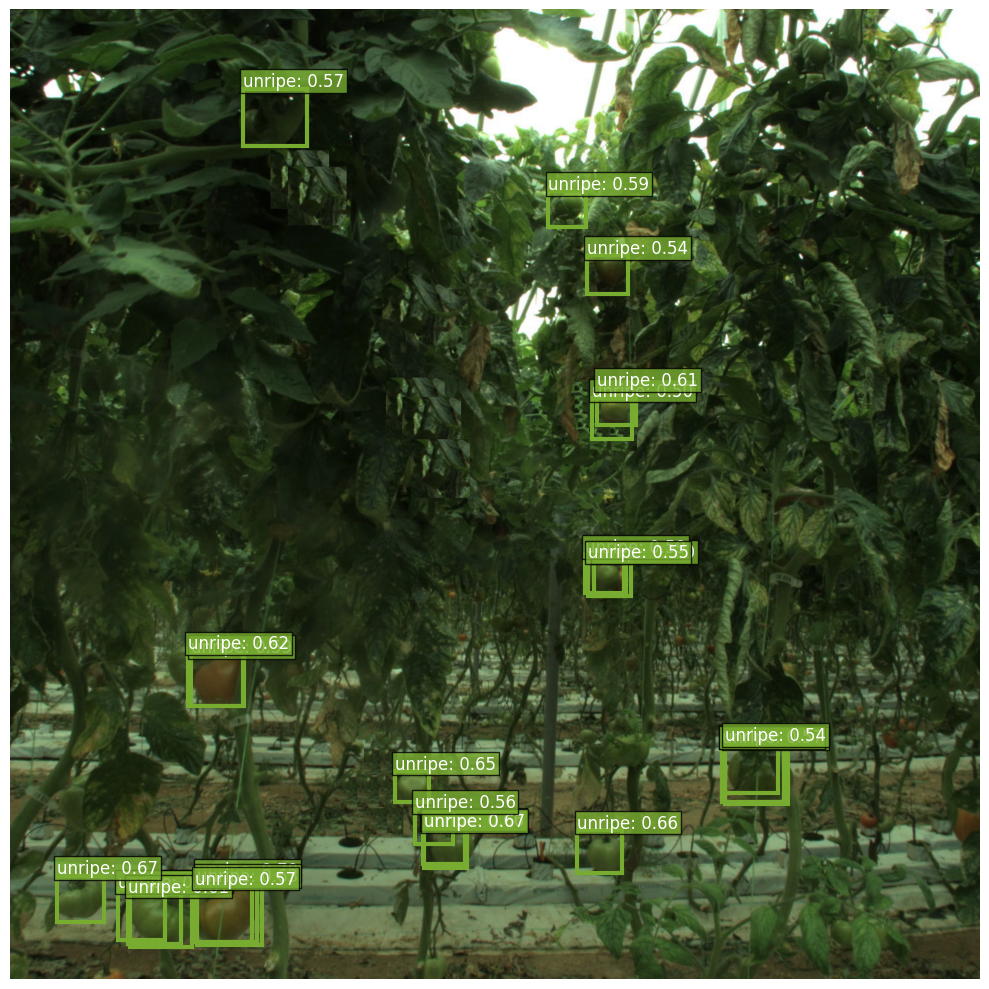

In [99]:
# =============================================================================
# Test 이미지에서 추론 (Inference)
# =============================================================================

from pathlib import Path

# Test 이미지 하나 로드
test_images = list((Path(test_3_path) / "images").glob("*.jpg"))
test_img_path = test_images[4]
test_image = Image.open(test_img_path)

print(f"Test 이미지: {test_img_path.name}")
print(f"   크기: {test_image.size}")

# 이미지 전처리
inputs = imageprocessor(images=test_image, return_tensors="pt")

# 추론
model.eval()
model.to(device)

with torch.no_grad():
    pixel_values = inputs["pixel_values"].to(device)
    pixel_mask = inputs["pixel_mask"].to(device) if "pixel_mask" in inputs else None
    
    outputs = model(pixel_values, pixel_mask)

# 결과 시각화
print("\nDetection 결과:")
visualize_predictions(test_image, outputs, ID2LABEL_3, threshold=0.5)

In [ ]:
# =============================================================================
# 저장된 체크포인트에서 모델 로드 (학습 후 사용)
# =============================================================================

import os

# 체크포인트 폴더 확인
checkpoint_dir = "../checkpoints"

# 체크포인트 파일 목록 출력
if os.path.exists(checkpoint_dir):
    ckpt_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.ckpt')]
else:
    print("[WARNING] checkpoints 폴더가 없습니다.")

# 체크포인트 경로 설정 (가장 최근 또는 best 모델 선택)
checkpoint_path = os.path.join(checkpoint_dir, ckpt_files[-1]) if ckpt_files else None

if checkpoint_path and os.path.exists(checkpoint_path):
    print(f"\n로드할 체크포인트: {checkpoint_path}")
    
    # 체크포인트에서 모델 로드
    trained_model = Detr.load_from_checkpoint(
        checkpoint_path,
        num_labels=1  # 1클래스
    )
    trained_model.eval()
    trained_model.to(device)
    
    print("[DONE]")
else:
    print("[WARNING]")

In [ ]:
# =============================================================================
# 여러 Test 이미지에서 추론 및 시각화
# =============================================================================

# 랜덤으로 4개 이미지 선택
import random
sample_images = random.sample(test_images, min(4, len(test_images)))

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

model.eval()
for ax, img_path in zip(axes, sample_images):
    image = Image.open(img_path)
    inputs = imageprocessor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        pixel_values = inputs["pixel_values"].to(device)
        pixel_mask = inputs["pixel_mask"].to(device) if "pixel_mask" in inputs else None
        
        outputs = model(pixel_values, pixel_mask)
    
    # 결과 그리기
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.5
    bboxes = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
    
    ax.imshow(image)
    for p, (xmin, ymin, xmax, ymax) in zip(probas[keep], bboxes.tolist()):
        cl = p.argmax()
        color = COLORS[cl % len(COLORS)]
        ax.add_patch(plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=color, linewidth=2
        ))
        ax.text(xmin, ymin - 5, f'{ID2LABEL_3[int(cl)]}: {p[cl]:.2f}',
                fontsize=10, color='white',
                bbox=dict(facecolor=color, alpha=0.8, pad=1))
    
    ax.set_title(img_path.name, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

----

## 1 class

In [17]:
# 파일 루트 지정
class_1_path = get_project_path("data", "TomatOD_COCO_1")
train_1_path = os.path.join(class_1_path, "train")
val_1_path = os.path.join(class_1_path, "val")
test_1_path = os.path.join(class_1_path, "test")
class_1= ['tomato']

In [11]:
# 클래스 매핑
CLASS_1_MAPPING = {
    "tomato": 0
}
ID2LABEL_1 = {v: k for k, v in CLASS_1_MAPPING.items()}
LABEL2ID_1 = CLASS_1_MAPPING

In [24]:
# 데이터셋 생성
train_dataset = CocoDetection(
    img_folder=os.path.join(train_1_path, "images"),
    ann_file=os.path.join(train_1_path, "custom_train.json"),
    imageprocessor=imageprocessor,
    train=True
)

val_dataset = CocoDetection(
    img_folder=os.path.join(val_1_path, "images"),
    ann_file=os.path.join(val_1_path, "custom_val.json"),
    imageprocessor=imageprocessor,
    train=False
)

print(f"   - Train: {len(train_dataset)}개")
print(f"   - Val: {len(val_dataset)}개")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
   - Train: 193개
   - Val: 54개


In [25]:
# ===================================
# 데이터셋 샘플 확인
# ===================================

# 샘플 하나 가져오기
pixel_values, target = train_dataset[0]

print("샘플 데이터 확인:")
print(f"   - pixel_values shape: {pixel_values.shape}")
print(f"   - target keys: {target.keys()}")
print(f"   - boxes shape: {target['boxes'].shape}")
print(f"   - class_labels: {target['class_labels']}")
print(f"   - class names: {[ID2LABEL_1[int(c)] for c in target['class_labels']]}")


샘플 데이터 확인:
   - pixel_values shape: torch.Size([3, 800, 800])
   - target keys: KeysView({'size': tensor([800, 800]), 'image_id': tensor([1]), 'class_labels': tensor([0, 0, 0, 0, 0, 0, 0]), 'boxes': tensor([[0.6610, 0.1475, 0.0770, 0.0770],
        [0.3650, 0.1045, 0.0770, 0.0770],
        [0.7995, 0.3520, 0.0440, 0.0440],
        [0.7415, 0.5070, 0.0850, 0.0850],
        [0.7325, 0.1555, 0.0680, 0.0680],
        [0.2985, 0.3060, 0.0680, 0.0680],
        [0.7555, 0.6285, 0.0500, 0.0500]]), 'area': tensor([3794.5598, 3794.5598, 1239.0399, 4624.0000, 2959.3599, 2959.3599,
        1600.0000]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]), 'orig_size': tensor([2000, 2000])})
   - boxes shape: torch.Size([7, 4])
   - class_labels: tensor([0, 0, 0, 0, 0, 0, 0])
   - class names: ['tomato', 'tomato', 'tomato', 'tomato', 'tomato', 'tomato', 'tomato']


In [26]:
# ===================================
# DataLoader 생성
# ===================================

BATCH_SIZE = 4
collate_fn = create_collate_fn(imageprocessor)

train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Windows에서는 0 권장
)

val_dataloader = DataLoader(
    val_dataset,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"[DONE] DataLoader 생성 완료")
print(f"   - Train batches: {len(train_dataloader)}")
print(f"   - Val batches: {len(val_dataloader)}")


[DONE] DataLoader 생성 완료
   - Train batches: 49
   - Val batches: 14


In [ ]:
# =============================================================================
# 모델 초기화 및 테스트 Forward Pass
# =============================================================================

# 모델 생성
NUM_LABELS = len(CLASS_1_MAPPING)  # 1개 클래스

model = Detr(
    num_labels=NUM_LABELS,
    lr=1e-4,
    lr_backbone=1e-5,
    weight_decay=1e-4,
    score_threshold=0.5
)

print(f"[DONE] 모델 초기화 완료")
print(f"   - num_labels: {NUM_LABELS}")
print(f"   - classes: {list(CLASS_1_MAPPING.keys())}")

# 테스트 forward pass
model.eval()
with torch.no_grad():
    test_batch = next(iter(train_dataloader))
    outputs = model(test_batch['pixel_values'], test_batch['pixel_mask'])
    print(f"\nForward pass 테스트:")
    print(f"   - logits shape: {outputs.logits.shape}")
    print(f"   - pred_boxes shape: {outputs.pred_boxes.shape}")

c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta p

[DONE] 모델 초기화 완료
   - num_labels: 1
   - classes: ['tomato']

Forward pass 테스트:
   - logits shape: torch.Size([4, 100, 2])
   - pred_boxes shape: torch.Size([4, 100, 4])


In [32]:
# ===============================
# 학습 실행
# ===============================
# 이 셀은 실제 학습을 시작합니다. GPU 메모리와 시간이 필요합니다.

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# 체크포인트 콜백
checkpoint_callback = ModelCheckpoint(
    dirpath="../checkpoints",
    filename="detr-tomatod-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min"
)

# Early stopping 콜백
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min"
)

# Trainer 설정
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=10,
    val_check_interval=1.0,
)

print("[DONE] Trainer 설정 완료")
print(f"   - max_epochs: 50")
print(f"   - device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print("\n학습을 시작하려면 아래 셀을 실행하세요.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


[DONE] Trainer 설정 완료
   - max_epochs: 50
   - device: GPU

학습을 시작하려면 아래 셀을 실행하세요.


In [33]:
# =============================================================================
# 학습 시작 (이 셀 실행 시 학습 시작)
# =============================================================================
# GPU 메모리가 부족하면 BATCH_SIZE를 줄이세요

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader
)

print("\n 학습 완료!")
print(f"   Best model: {checkpoint_callback.best_model_path}")

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode | FLOPs
---------------------------------------------------------------------
0 | model      | DetrForObjectDetection | 41.5 M | eval | 0    
1 | map_metric | MeanAveragePrecision   | 0      | eval | 0    
---------------------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.007   Total estimated model params size (MB)
0         Modules in train mode
400       Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:01<00:01,  0.88it/s]

c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: You called `self.log('val_classes', ...)` in your `on_validation_epoch_end` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'val_classes': ...})` instead.
c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:534: Found 401 module(s) in eval mode 

Epoch 0: 100%|██████████| 49/49 [01:02<00:00,  0.79it/s, v_num=0, train_loss=3.850]

c:\Users\KIST\tomato-detection-agentic\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 33: 100%|██████████| 49/49 [01:06<00:00,  0.74it/s, v_num=0, train_loss=0.515, val_loss=1.230, val_map=0.338, val_map_50=0.750, val_map_75=0.225, val_map_small=0.338, val_map_medium=-1.00, val_map_large=-1.00, val_mar_1=0.0573, val_mar_10=0.363, val_mar_100=0.427, val_mar_small=0.427, val_mar_medium=-1.00, val_mar_large=-1.00, val_map_per_class=0.338, val_mar_100_per_class=0.427, val_classes=0.000] 

 학습 완료!
   Best model: C:\Users\KIST\tomato-detection-agentic\checkpoints\detr-tomatod-epoch=28-val_loss=1.15.ckpt


Test 이미지: stereo20190405_133623_p1_snap_136.jpg
   크기: (2000, 2000)

Detection 결과:


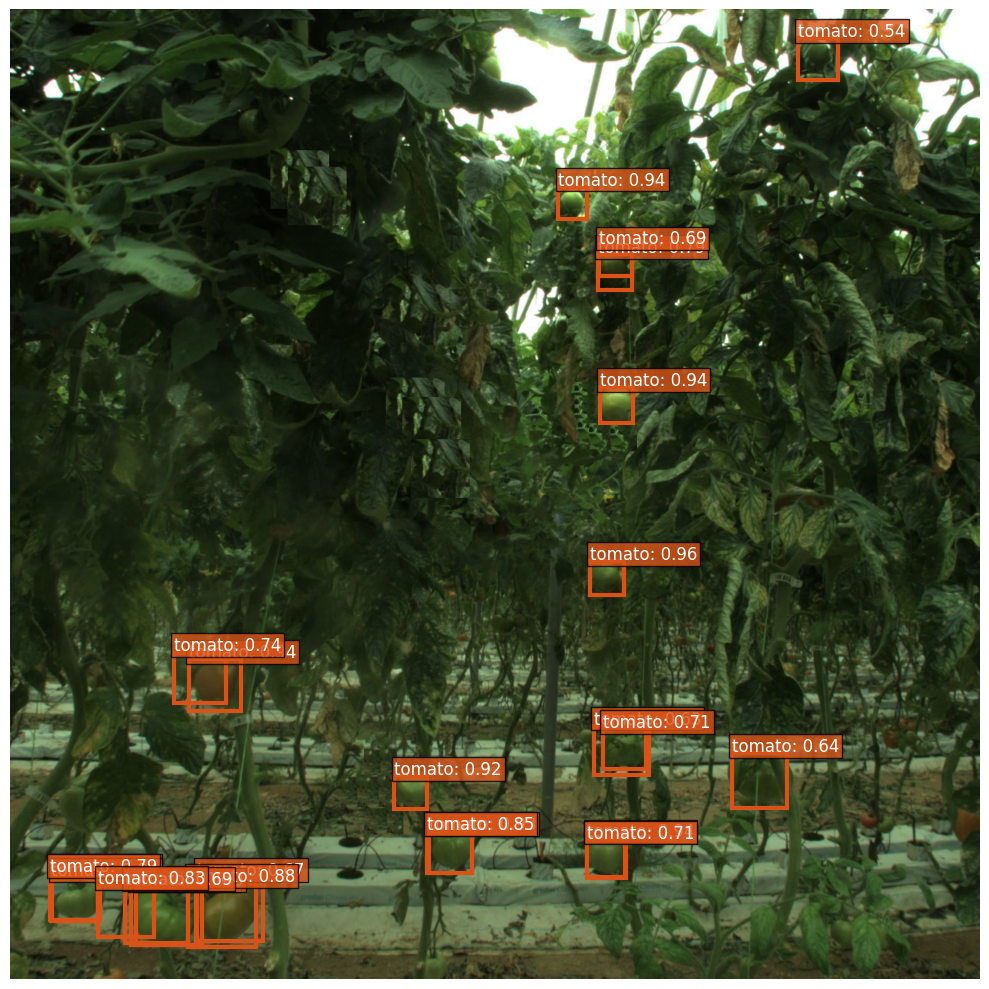

In [44]:
# =============================================================================
# Test 이미지에서 추론 (Inference)
# =============================================================================

from pathlib import Path

# Test 이미지 하나 로드
test_images = list((Path(test_1_path) / "images").glob("*.jpg"))
test_img_path = test_images[4]
test_image = Image.open(test_img_path)

print(f"Test 이미지: {test_img_path.name}")
print(f"   크기: {test_image.size}")

# 이미지 전처리
inputs = imageprocessor(images=test_image, return_tensors="pt")

# 추론
model.eval()
model.to(device)

with torch.no_grad():
    pixel_values = inputs["pixel_values"].to(device)
    pixel_mask = inputs["pixel_mask"].to(device) if "pixel_mask" in inputs else None
    
    outputs = model(pixel_values, pixel_mask)

# 결과 시각화
print("\nDetection 결과:")
visualize_predictions(test_image, outputs, ID2LABEL_1, threshold=0.5)

In [52]:
# =============================================================================
# 저장된 체크포인트에서 모델 로드 (학습 후 사용)
# =============================================================================

import os

# 체크포인트 폴더 확인
checkpoint_dir = "../checkpoints"

# 체크포인트 파일 목록 출력
if os.path.exists(checkpoint_dir):
    ckpt_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.ckpt')]
else:
    print("[WARNING] checkpoints 폴더가 없습니다.")

# 체크포인트 경로 설정 (가장 최근 또는 best 모델 선택)
checkpoint_path = os.path.join(checkpoint_dir, ckpt_files[-1]) if ckpt_files else None

if checkpoint_path and os.path.exists(checkpoint_path):
    print(f"\n로드할 체크포인트: {checkpoint_path}")
    
    # 체크포인트에서 모델 로드
    trained_model = Detr.load_from_checkpoint(
        checkpoint_path,
        num_labels=1  # 1클래스
    )
    trained_model.eval()
    trained_model.to(device)
    
    print("[DONE]")
else:
    print("[WARNING]")


로드할 체크포인트: ../checkpoints\detr-tomatod-epoch=28-val_loss=1.15.ckpt


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

[DONE]


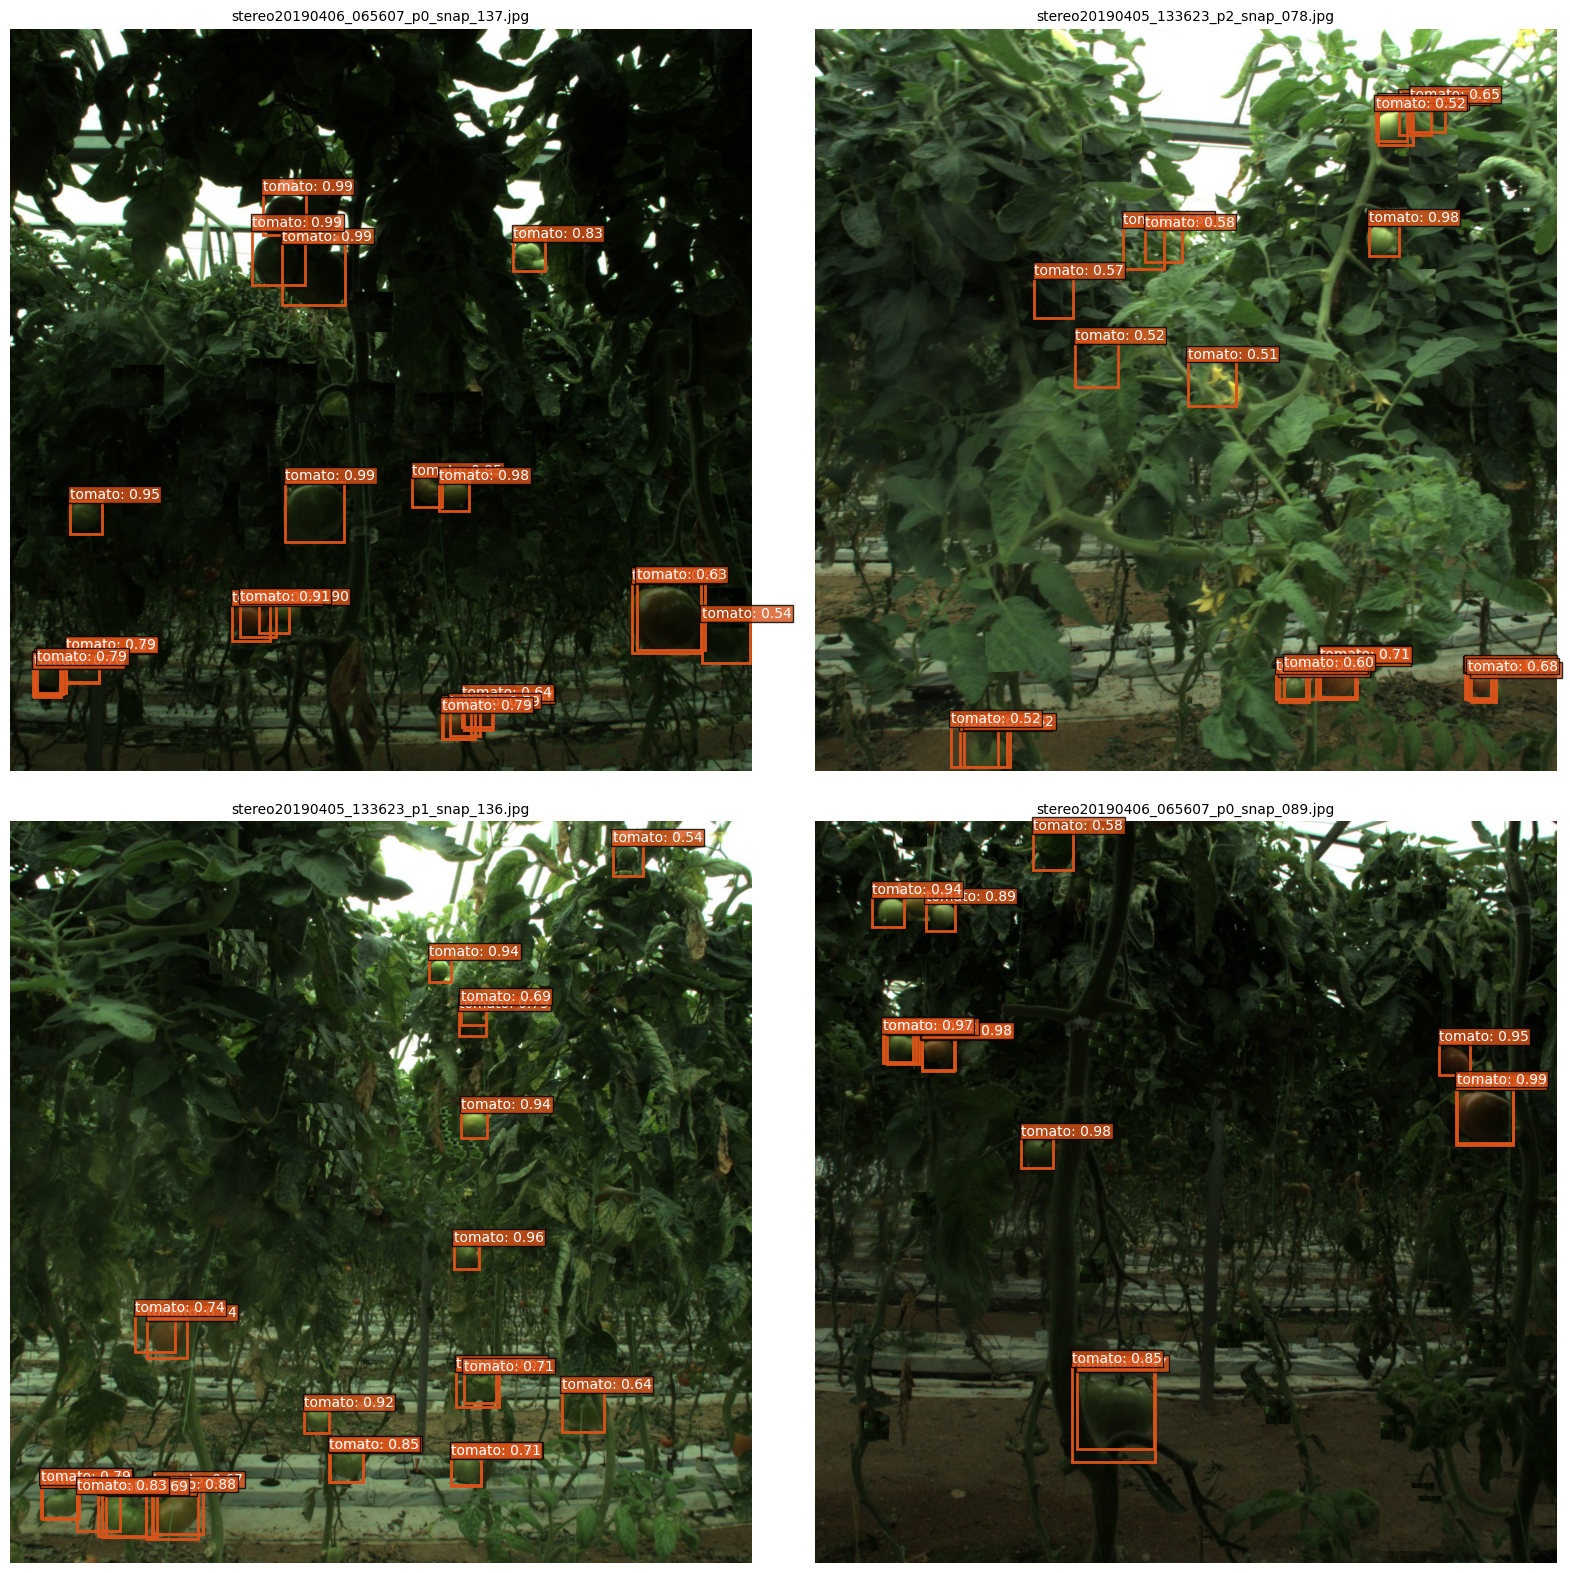

In [61]:
# =============================================================================
# 여러 Test 이미지에서 추론 및 시각화
# =============================================================================

# 랜덤으로 4개 이미지 선택
import random
sample_images = random.sample(test_images, min(4, len(test_images)))

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

model.eval()
for ax, img_path in zip(axes, sample_images):
    image = Image.open(img_path)
    inputs = imageprocessor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        pixel_values = inputs["pixel_values"].to(device)
        pixel_mask = inputs["pixel_mask"].to(device) if "pixel_mask" in inputs else None
        
        outputs = model(pixel_values, pixel_mask)
    
    # 결과 그리기
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.5
    bboxes = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
    
    ax.imshow(image)
    for p, (xmin, ymin, xmax, ymax) in zip(probas[keep], bboxes.tolist()):
        cl = p.argmax()
        color = COLORS[cl % len(COLORS)]
        ax.add_patch(plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=color, linewidth=2
        ))
        ax.text(xmin, ymin - 5, f'{ID2LABEL_1[int(cl)]}: {p[cl]:.2f}',
                fontsize=10, color='white',
                bbox=dict(facecolor=color, alpha=0.8, pad=1))
    
    ax.set_title(img_path.name, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [88]:
# Test 데이터셋 생성 (3-class 기준)
test_dataset = CocoDetection(
    img_folder=os.path.join(test_1_path, "images"),
    ann_file=os.path.join(test_1_path, "custom_test.json"),
    imageprocessor=imageprocessor,
    train=False
)

test_dataloader = DataLoader(
    test_dataset,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"Test 데이터셋 로드 완료")
print(f"   - Test 이미지 수: {len(test_dataset)}개")
print(f"   - Test 배치 수: {len(test_dataloader)}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Test 데이터셋 로드 완료
   - Test 이미지 수: 30개
   - Test 배치 수: 8


In [95]:
# =============================================================================
# Detection 및 Classification 평가 함수 (FP/TP/FN 추가)
# =============================================================================

def box_iou(boxes1, boxes2):
    """
    CXCYWH 형식의 박스 IoU 계산
    """
    from torchvision.ops import box_iou as tv_box_iou
    
    # CXCYWH -> XYXY 변환
    def cxcywh_to_xyxy(boxes):
        cx, cy, w, h = boxes.unbind(-1)
        x1 = cx - w / 2
        y1 = cy - h / 2
        x2 = cx + w / 2
        y2 = cy + h / 2
        return torch.stack([x1, y1, x2, y2], dim=-1)
    
    boxes1_xyxy = cxcywh_to_xyxy(boxes1)
    boxes2_xyxy = cxcywh_to_xyxy(boxes2)
    
    return tv_box_iou(boxes1_xyxy, boxes2_xyxy)

def evaluate_model(model, dataloader, id2label, score_threshold=0.5, iou_threshold=0.5, device='cuda'):
    """
    Detection과 Classification 지표를 모두 계산 (FP/TP/FN 포함)
    
    Args:
        iou_threshold: TP로 간주할 최소 IoU (기본값 0.5)
    """
    model.eval()
    model.to(device)
    
    # Detection metric 초기화
    map_metric = MeanAveragePrecision(
        box_format="cxcywh", 
        iou_type="bbox",
        class_metrics=True
    )
    
    # Classification을 위한 리스트
    all_true_labels = []
    all_pred_labels = []
    
    # Detection 통계
    total_predictions = 0
    total_ground_truths = 0
    
    # TP, FP, FN 통계
    total_tp = 0
    total_fp = 0
    total_fn = 0
    
    print("\n테스트 데이터 평가 중...")
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            pixel_values = batch["pixel_values"].to(device)
            pixel_mask = batch.get("pixel_mask")
            if pixel_mask is not None:
                pixel_mask = pixel_mask.to(device)
            
            labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]
            
            # 모델 추론
            outputs = model(pixel_values, pixel_mask)
            
            # Detection metric용 데이터 준비
            probs = outputs.logits.softmax(-1)[..., :-1]
            scores, pred_labels = probs.max(-1)
            pred_boxes = outputs.pred_boxes
            
            preds = []
            targets = []
            
            for i in range(pred_boxes.shape[0]):
                # Prediction 필터링
                keep = scores[i] > score_threshold
                
                pred_boxes_filtered = pred_boxes[i][keep].detach().cpu()
                pred_scores_filtered = scores[i][keep].detach().cpu()
                pred_labels_filtered = pred_labels[i][keep].detach().cpu()
                
                preds.append({
                    "boxes": pred_boxes_filtered,
                    "scores": pred_scores_filtered,
                    "labels": pred_labels_filtered,
                })
                
                # Ground truth
                gt_boxes = labels[i]["boxes"].detach().cpu()
                gt_labels = labels[i]["class_labels"].detach().cpu()
                
                targets.append({
                    "boxes": gt_boxes,
                    "labels": gt_labels,
                })
                
                # TP, FP, FN 계산
                num_preds = len(pred_boxes_filtered)
                num_gts = len(gt_boxes)
                
                if num_preds > 0 and num_gts > 0:
                    # IoU 계산
                    iou_matrix = box_iou(pred_boxes_filtered, gt_boxes)
                    
                    # 각 예측에 대해 가장 높은 IoU를 가진 GT 찾기
                    max_ious, matched_gt_indices = iou_matrix.max(dim=1)
                    
                    # TP: IoU >= threshold인 예측
                    tp = (max_ious >= iou_threshold).sum().item()
                    
                    # FP: IoU < threshold인 예측
                    fp = (max_ious < iou_threshold).sum().item()
                    
                    # FN: 매칭되지 않은 GT
                    matched_gt_mask = torch.zeros(num_gts, dtype=torch.bool)
                    matched_gt_mask[matched_gt_indices[max_ious >= iou_threshold]] = True
                    fn = (~matched_gt_mask).sum().item()
                    
                elif num_preds > 0 and num_gts == 0:
                    # GT가 없는데 예측이 있음 -> 모두 FP
                    tp = 0
                    fp = num_preds
                    fn = 0
                    
                elif num_preds == 0 and num_gts > 0:
                    # 예측이 없는데 GT가 있음 -> 모두 FN
                    tp = 0
                    fp = 0
                    fn = num_gts
                    
                else:
                    tp = fp = fn = 0
                
                total_tp += tp
                total_fp += fp
                total_fn += fn
                
                # Classification 평가를 위한 데이터 수집
                if len(gt_labels) > 0:
                    for gt_label in gt_labels:
                        all_true_labels.append(gt_label.item())
                    
                    if len(pred_labels_filtered) > 0:
                        for pred_label in pred_labels_filtered:
                            all_pred_labels.append(pred_label.item())
                    
                total_predictions += len(pred_boxes_filtered)
                total_ground_truths += len(gt_boxes)
            
            # Detection metric 업데이트
            if preds:
                map_metric.update(preds, targets)
    
    # Detection 지표 계산
    detection_metrics = map_metric.compute()
    
    # Precision, Recall, F1 계산
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # 결과 출력
    print("\n" + "="*70)
    print("DETECTION 평가 결과")
    print("="*70)
    
    print(f"\n[전체 통계]")
    print(f"  총 Ground Truth 객체 수: {total_ground_truths}")
    print(f"  총 예측된 객체 수 (threshold > {score_threshold}): {total_predictions}")
    
    print(f"\n[Detection 성능 (IoU >= {iou_threshold})]")
    print(f"  True Positives (TP):  {total_tp:4d} ({total_tp/total_predictions*100:.1f}%)" if total_predictions > 0 else f"  True Positives (TP):  {total_tp:4d}")
    print(f"  False Positives (FP): {total_fp:4d} ({total_fp/total_predictions*100:.1f}%)" if total_predictions > 0 else f"  False Positives (FP): {total_fp:4d}")
    print(f"  False Negatives (FN): {total_fn:4d} ({total_fn/total_ground_truths*100:.1f}%)" if total_ground_truths > 0 else f"  False Negatives (FN): {total_fn:4d}")
    
    print(f"\n[Precision / Recall / F1]")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score:  {f1_score:.4f} ({f1_score*100:.2f}%)")
    
    print(f"\n[mAP 지표]")
    print(f"  mAP (IoU=0.50:0.95): {detection_metrics['map']:.4f}")
    print(f"  mAP@0.50: {detection_metrics['map_50']:.4f}")
    print(f"  mAP@0.75: {detection_metrics['map_75']:.4f}")
    
    print(f"\n[크기별 mAP]")
    print(f"  mAP (small): {detection_metrics['map_small']:.4f}")
    print(f"  mAP (medium): {detection_metrics['map_medium']:.4f}")
    print(f"  mAP (large): {detection_metrics['map_large']:.4f}")
    
    print(f"\n[Recall 지표]")
    print(f"  mAR (max 1 det): {detection_metrics['mar_1']:.4f}")
    print(f"  mAR (max 10 det): {detection_metrics['mar_10']:.4f}")
    print(f"  mAR (max 100 det): {detection_metrics['mar_100']:.4f}")
    
    # Per-class AP
    if 'map_per_class' in detection_metrics:
        print(f"\n[클래스별 AP (IoU=0.50:0.95)]")
        map_per_class = detection_metrics['map_per_class']
        
        if map_per_class.ndim == 0:
            if 0 in id2label:
                print(f"  {id2label[0]}: {map_per_class:.4f}")
        else:
            for i, ap in enumerate(map_per_class):
                if i < len(id2label):
                    print(f"  {id2label[i]}: {ap:.4f}")
    
    # Classification 리포트
    print("\n" + "="*70)
    print("CLASSIFICATION 평가 결과")
    print("="*70)
    
    if len(all_true_labels) > 0 and len(all_pred_labels) > 0:
        min_len = min(len(all_true_labels), len(all_pred_labels))
        all_true_labels = all_true_labels[:min_len]
        all_pred_labels = all_pred_labels[:min_len]
        
        target_names = [id2label[i] for i in range(len(id2label))]
        print("\n[분류 성능 리포트]")
        
        if len(target_names) > 1:
            print(classification_report(
                all_true_labels, 
                all_pred_labels, 
                target_names=target_names,
                zero_division=0
            ))
            
            cm = confusion_matrix(all_true_labels, all_pred_labels)
            
            print("\n[Confusion Matrix]")
            plt.figure(figsize=(10, 8))
            sns.heatmap(
                cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names
            )
            plt.title('Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()
            plt.show()
            
            return detection_metrics, classification_report(
                all_true_labels, 
                all_pred_labels, 
                target_names=target_names,
                output_dict=True,
                zero_division=0
            ), cm
        else:
            print("1-class 모델이므로 classification 평가는 해당되지 않습니다.")
            return detection_metrics, None, None
    else:
        print("예측된 객체가 없어 Classification 평가를 수행할 수 없습니다.")
        return detection_metrics, None, None

print("[DONE] 평가 함수 정의 완료")

[DONE] 평가 함수 정의 완료


In [ ]:
# =============================================================================
# 평가 실행 (1-class 모델)
# =============================================================================

# 체크포인트에서 모델 로드
checkpoint_path = "../checkpoints/detr-tomatod-epoch=28-val_loss=1.15.ckpt"

if os.path.exists(checkpoint_path):
    print(f"\n체크포인트 로드: {checkpoint_path}")
    
    # 1-class 모델 로드 (체크포인트가 1-class로 학습됨)
    model_1class = Detr.load_from_checkpoint(
        checkpoint_path,
        num_labels=1
    )
    
    # 1-class 데이터셋으로 평가
    detection_metrics, classification_metrics, cm = evaluate_model(
        model=model_1class,
        dataloader=test_dataloader,  # test_dataloader (1-class용)
        id2label=ID2LABEL_1,  # ID2LABEL_1 사용
        score_threshold=0.5,
        device=devfice
    )
    
    print("\n✅ 평가 완료!")
else:
    print(f"❌ 체크포인트 파일을 찾을 수 없습니다: {checkpoint_path}")


체크포인트 로드: ../checkpoints/detr-tomatod-epoch=28-val_loss=1.15.ckpt


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin


테스트 데이터 평가 중...


Evaluating: 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


DETECTION 평가 결과

[전체 통계]
  총 Ground Truth 객체 수: 279
  총 예측된 객체 수 (threshold > 0.5): 406

[Detection 성능 (IoU >= 0.5)]
  True Positives (TP):   273 (67.2%)
  False Positives (FP):  133 (32.8%)
  False Negatives (FN):   42 (15.1%)

[Precision / Recall / F1]
  Precision: 0.6724 (67.24%)
  Recall:    0.8667 (86.67%)
  F1-Score:  0.7573 (75.73%)

[mAP 지표]
  mAP (IoU=0.50:0.95): 0.4193
  mAP@0.50: 0.8137
  mAP@0.75: 0.3662

[크기별 mAP]
  mAP (small): 0.4193
  mAP (medium): -1.0000
  mAP (large): -1.0000

[Recall 지표]
  mAR (max 1 det): 0.0731
  mAR (max 10 det): 0.4355
  mAR (max 100 det): 0.4921

[클래스별 AP (IoU=0.50:0.95)]
  tomato: 0.4193

CLASSIFICATION 평가 결과

[분류 성능 리포트]
1-class 모델이므로 classification 평가는 해당되지 않습니다.

✅ 평가 완료!
